## Import Libraries


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## Data Preprocessing

In [2]:
wq_data = pd.read_csv("water_potability.csv")
print("Number of entries: ", wq_data.shape[0])
print("Number of columns: ", wq_data.shape[1])

Number of entries:  3276
Number of columns:  10


Target value is 'Potability' column, the rest of them are going to be features. Potability shows if water is safe for human consumption where 1: potable (safe) and 0: not potable.

In [3]:
list(wq_data.columns)

['ph',
 'Hardness',
 'Solids',
 'Chloramines',
 'Sulfate',
 'Conductivity',
 'Organic_carbon',
 'Trihalomethanes',
 'Turbidity',
 'Potability']

The dataset contains missing values in three columns: ph, Sulfate, and Trihalomethanes. Instead of just dropping missing values, let's impute median, since all the values are continuous variables. However, we will do it a little bit later.

In [4]:
missing_values = wq_data.isnull().sum()
missing_values, "--------------------", wq_data.dtypes

(ph                 491
 Hardness             0
 Solids               0
 Chloramines          0
 Sulfate            781
 Conductivity         0
 Organic_carbon       0
 Trihalomethanes    162
 Turbidity            0
 Potability           0
 dtype: int64,
 '--------------------',
 ph                 float64
 Hardness           float64
 Solids             float64
 Chloramines        float64
 Sulfate            float64
 Conductivity       float64
 Organic_carbon     float64
 Trihalomethanes    float64
 Turbidity          float64
 Potability           int64
 dtype: object)

## Exploratory Data Analysis

- Summary statistics.
- Distribution of features.
- Correlation analysis.

In [9]:
#basic information
print(wq_data.describe())

                ph     Hardness        Solids  Chloramines      Sulfate  \
count  2785.000000  3276.000000   3276.000000  3276.000000  2495.000000   
mean      7.080795   196.369496  22014.092526     7.122277   333.775777   
std       1.594320    32.879761   8768.570828     1.583085    41.416840   
min       0.000000    47.432000    320.942611     0.352000   129.000000   
25%       6.093092   176.850538  15666.690297     6.127421   307.699498   
50%       7.036752   196.967627  20927.833607     7.130299   333.073546   
75%       8.062066   216.667456  27332.762127     8.114887   359.950170   
max      14.000000   323.124000  61227.196008    13.127000   481.030642   

       Conductivity  Organic_carbon  Trihalomethanes    Turbidity   Potability  
count   3276.000000     3276.000000      3114.000000  3276.000000  3276.000000  
mean     426.205111       14.284970        66.396293     3.966786     0.390110  
std       80.824064        3.308162        16.175008     0.780382     0.487849  


The distribution of data classes is slightly unbalanced. We see that about 60% of samples are labeled 0 Not Potable and 40% as Potable (1). This imbalance can imply:
- Bias towards majority class
- The minority class (class 1) might be under-represented in the model's training process, leading to less reliable predictions for that class.
- Traditional accuracy metrics might be misleading.

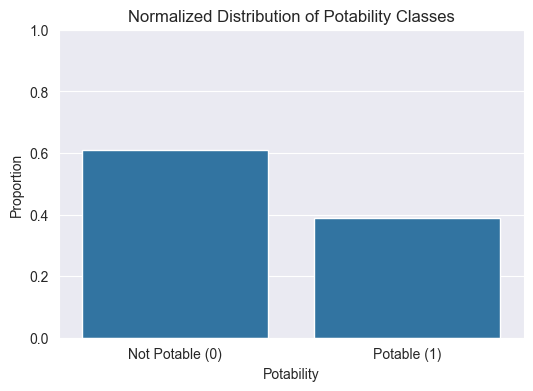

In [8]:
class_counts = wq_data['Potability'].value_counts(normalize=True)  # Getting proportions

# Plotting
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Normalized Distribution of Potability Classes')
plt.xlabel('Potability')
plt.ylabel('Proportion')
plt.ylim(0, 1)  # Setting scale from 0 to 1
plt.xticks([0, 1], ['Not Potable (0)', 'Potable (1)'])  # Renaming x-ticks for clarity
plt.show()

Using heatmap to visualize the correlations between different features can help to reveal which features are strongly correlated with Potability.


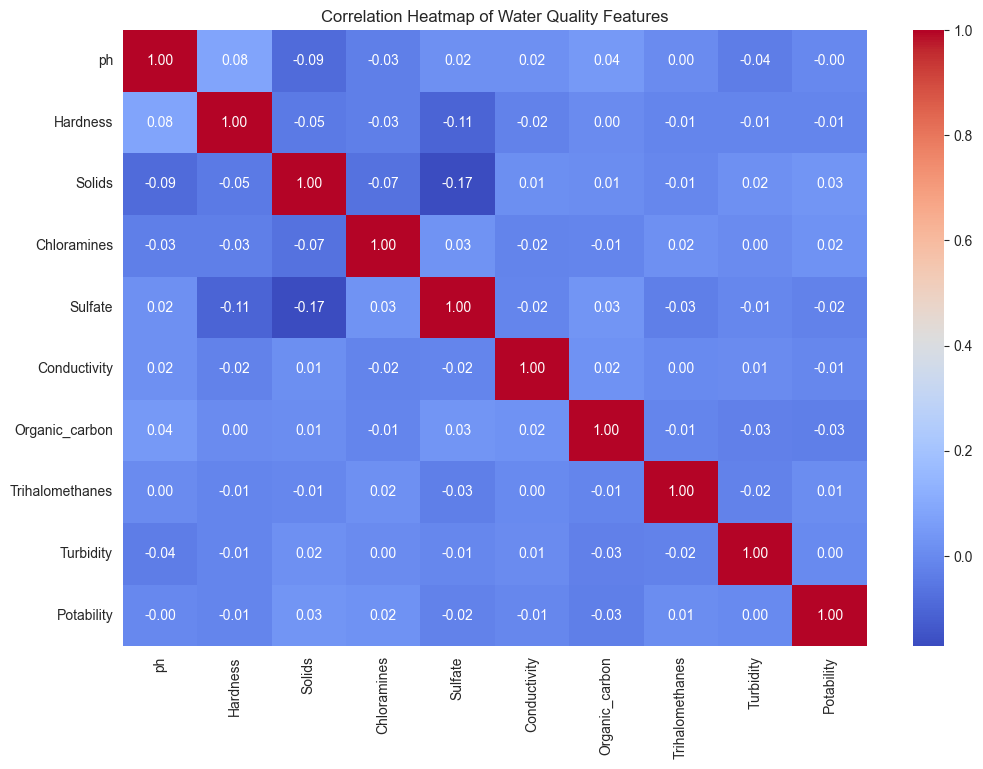

In [10]:
corr_matrix = wq_data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Water Quality Features')
plt.show()

From the Heatmap we can see that there is no strong correlation between features and target Potability. In general, most features have low to moderate correlations with each other.
To reveal more complex, non-linear relationships between features we will use machine learning models.

## Data Preprocessing for Modeling

From preprocessing our dataset, we already have seen that there are quite some amount of missing values. If we impute missing values using the entire dataset before splitting into training and testing sets, we inadvertently introduce information from the test set into the training process. This is because the imputation process would use data (our mean) that is calculated from the entire dataset, influencing the imputed values in the training set. To avoid this, we first split our data. Calculate imputation values (mean) only from the training set.

In [8]:
X = wq_data.drop('Potability', axis=1)  # Features
y = wq_data['Potability']                # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Imputing missing values in training set
imputer = SimpleImputer(strategy="median")
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)  # Note: 'transform' and not 'fit_transform'

# Normalizing or scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)  # ! only 'transform' is used

In [9]:
print("Training set (X_train, y_train):", X_train.shape, y_train.shape)
print("Test set (X_test, y_test):", X_test.shape, y_test.shape)

Training set (X_train, y_train): (2620, 9) (2620,)
Test set (X_test, y_test): (656, 9) (656,)


## Model Development and Evaluation